# Mohr circle and stress paths

© 2022 Exneyder A. Montoya-Araque, Daniel F. Ruiz and Universidad EAFIT.

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/eamontoyaa/EAFIT_slope_stability/blob/main/notebooks/mohr_circles_and_stress_paths.ipynb).



## Required modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, widgets, fixed

## Global configuration for plots

In [2]:
plt.style.use("default")
# plt.rcParams["image.cmap"] = "brg"
# mpl.rcParams['axes.color_cycle'] = plt.get_cmap("brg")
mpl.rcParams.update(
    {
        "font.family": "serif",  # Use the Computer modern font
        "font.serif": "cmr10",
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)


## Ejercicio

El siguiente ejercio se plantea y desarrolla a partir del originalmente publicado por [S. Olivella *et al.,* (2009)](http://hdl.handle.net/2099.3/36530).

En un punto de una arena compacta actúan unas tensiones $\sigma_{xx} = 7.0\,\mathrm{kg/cm^2}$ $(\sigma_\mathrm{h})$ y $\tau_{xy} = 2.2\,\mathrm{kg/cm^2}$ en un plano vertical, y $\sigma_{yy} = 5.0\,\mathrm{kg/cm^2}$ $(\sigma_\mathrm{v})$ en un plano horizontal. Este estado tensional inicial sufre sucesivamente las siguiente modificaciones:

a. Reducción de $\tau_{xy}$ hasta $0.0\,\mathrm{kg/cm^2}$

b. Aumento de $\sigma_{xx}$ hasta $8.42\,\mathrm{kg/cm^2}$ y disminución de $\sigma_{yy}$ hasta $3.58\,\mathrm{kg/cm^2}$

c. Reducción de $\tau_{yx}$ hasta $-2.0\,\mathrm{kg/cm^2}$

d. Aumento de $\sigma_\mathrm{v}$ hasta $8.42\,\mathrm{kg/cm^2}$ y reducción de $\sigma_\mathrm{h}$ hasta $3.58\,\mathrm{kg/cm^2}$

e. Aumento de $\sigma_{xx}$ hasta $10.0\,\mathrm{kg/cm^2}$ y de $\sigma_{yy}$ hasta $5.16\,\mathrm{kg/cm^2}$

f. Reducción de $\sigma_{yy}$ hasta $4.58\,\mathrm{kg/cm^2}$

g. Aumento indefinido de $\sigma_{xx}$.

Represente los círculos de Mohr del estado inicial y los sucesivos estados modificados.

Si se hace la hipótesis de que el suelo llega a rotura cuando $\tau_\mathrm{n} > 0.735 \sigma_\mathrm{n}$
en algún plano, ¿se llega a rotura en la trayectoria indicada? ¿Cuándo? ¿En qué plano se produce?


In [3]:
sigma_x = 7.0
sigma_yy = 5.0
tau_xy = 2.2

**Centro, $c$, y esfuerzo medio, $\sigma_\mathrm{m}$**
$$
c = \sigma_\mathrm{m} = \frac{1}{2} (\sigma_\mathrm{xx} + \sigma_\mathrm{yy})
$$

**Radio, $r$ y esfuerzo cortante máximo, $\tau_\mathrm{max}$**

$$
r = \tau_\mathrm{max} = \sqrt{\sigma_\mathrm{xx}^2 + (\tau_\mathrm{xy} - c)^2}
$$

In [4]:
def plot_mohr_circle(
    sigma_xx, sigma_yy, tau_xy, plot_envelope=False, plot_pole=False, plot_plane=False, alpha=0, xlim=(0, 20), ylim=(-7, 7)
):
    c = 0.5 * (sigma_xx + sigma_yy)
    r = np.sqrt((sigma_xx - c) ** 2 + tau_xy**2)
    sig_1 = r * np.cos(0) + c
    sig_3 = r * np.cos(np.pi) + c

    outcome = {
        "sig_1": sig_1,
        "sig_3": sig_3,
        "sig_xx": sigma_xx,
        "sig_yy": sigma_yy,
        "tau_xy": tau_xy,
        "s": 0.5 * (sig_1 + sig_3),
        "t": 0.5 * (sig_1 - sig_3),
        "p": 1 / 3 * (sig_1 + 2 * sig_3),
        "q": sig_1 - sig_3,
    }

    factor = 1.1
    theta = np.linspace(0, 2 * np.pi, 200)
    sigma = np.linspace(0, sig_1 * factor, 200)

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[6.5, 3.5])
    ax.axhline(y=0, xmin=0, xmax=sig_1 * factor, c="k")
    ax.plot(r * np.cos(theta) + c, r * np.sin(theta), c="k")  # Mohr circle

    label = "$\sigma_{1}=$" + f"{sig_1:.1f}"  # sigma_1
    ax.plot(sig_1, 0, ls="", c="#BB5566", marker=".", ms=12, label=label)
    label = "$\sigma_{3}=$" + f"{sig_3:.1f}"  # sigma_3
    ax.plot(sig_3, 0, ls="", c="#004488", marker=".", ms=12, label=label)
    label = "$\\tau_\mathrm{max}=$" + f"{r:.1f}"  # tau_max
    ax.plot(c, r, ls="", c="#cc3300", marker="P", ms=7, label=label)    
    # sigma_xx, tau_xy
    label = ("$\sigma_{xx}=$" + f"{sigma_xx:.1f}" + ", $\\tau_{xy}=$" + f"{tau_xy:.1f}")
    ax.plot(sigma_xx, tau_xy, ls="", c="#DDAA33", marker="s", label=label)
    # sigma_yy, (-)tau_xy
    label = ("$\sigma_{yy}=$" + f"{sigma_yy:.1f}" + ", $\\tau_{yx}=$" + f"{tau_xy:.1f}")
    ax.plot(sigma_yy, -1 * tau_xy, ls="", c="#117733", marker="s", label=label)

    if plot_envelope:  # Failure envelope
        label = "Failure criterion \n$\\tau_\mathrm{n} = 0.735 \sigma_\mathrm{n}$"
        ax.plot(sigma, 0.735 * sigma, c="r", label=label)

    if plot_pole:  # Pole and stress on a plane 
        ax.axhline(y=-1 * tau_xy, c="b", ls="--", lw=0.75)
        ax.axvline(x=sigma_xx, c="b", ls="--", lw=0.75)
        ax.plot(sigma_xx, -1 * tau_xy, ls="", c="k",marker="o",label="Pole")
    if  plot_plane:
        # beta = 0.5 * np.degrees(np.arctan(tau_xy/sigma_xx))
        beta = np.degrees(np.arctan((sig_1 - sigma_xx)/tau_xy))
        theta = alpha + beta
        plane_sig_n = r * np.cos(np.radians(2 * theta)) + c
        plane_tau_n = r * np.sin(np.radians(2 * theta))
        label = (
            "Stress state on the plane\n" + "$\sigma_\mathrm{n}=$" + f"{plane_sig_n:.1f}"
            + ", $\\tau_\mathrm{n}=$" + f"{plane_tau_n:.1f}"
        )
        ax.plot(plane_sig_n, plane_tau_n, ls="", c="r", marker="o", label=label)
        ax.plot(
            (plane_sig_n, sigma_xx), (plane_tau_n, -1 * tau_xy), c="r", ls="--", lw=0.75,
            label=f"Plano a {alpha:.2f}" + "$^{\circ}$ del plano $\sigma_\mathrm{11}$"
        )

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.grid(True, ls="--")
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_linewidth(1.5)
    # ax.axis("equal")
    ax.set_aspect("equal", adjustable=None, anchor='C')
    ax.set(
        xlabel="Normal stress, $\sigma_\mathrm{n}\;[\mathrm{kg/cm^2}]$",
        ylabel="Shear stress, $\\tau_\mathrm{n}\;[\mathrm{kg/cm^2}]$",
        # xlim=(0, sig_1 * factor),
        xlim=xlim,
        ylim=ylim
    )
    fig.tight_layout()
    return outcome


## Modificaciones al estado de esfuerzos inicial

### Estado inicial $\sigma_{xx} = \sigma_\mathrm{h}= 7.0\,\mathrm{\frac{kg}{cm^2}}$, $\sigma_{yy} = \sigma_\mathrm{v} = 5.0\,\mathrm{\frac{kg}{cm^2}}$, y $\tau_{xy} = 2.2\,\mathrm{\frac{kg}{cm^2}}$ 

{'sig_1': 8.416609194718914,
 'sig_3': 3.5833908052810854,
 'sig_xx': 7.0,
 'sig_yy': 5.0,
 'tau_xy': 2.2,
 's': 6.0,
 't': 2.416609194718914,
 'p': 5.194463601760361,
 'q': 4.833218389437828}

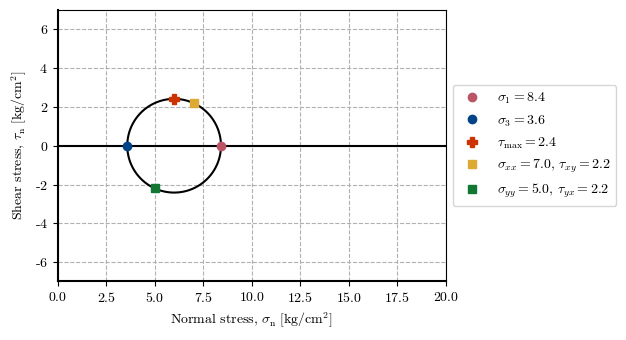

In [5]:
stage_0 = plot_mohr_circle(sigma_xx=7.0, sigma_yy=5.0, tau_xy=2.2)
stage_0

### a. Reducción de $\tau_{xy}$ hasta $0.0\,\mathrm{\frac{kg}{cm^2}}$

{'sig_1': 7.0,
 'sig_3': 5.0,
 'sig_xx': 7.0,
 'sig_yy': 5.0,
 'tau_xy': 0,
 's': 6.0,
 't': 1.0,
 'p': 5.666666666666666,
 'q': 2.0}

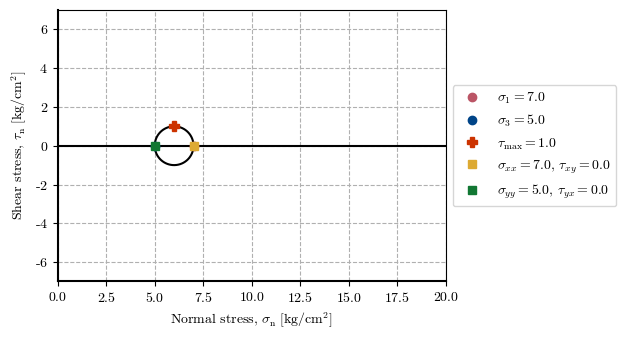

In [6]:
stage_a = plot_mohr_circle(sigma_xx=7.0, sigma_yy=5.0, tau_xy=0)
stage_a

### b. Aumento de $\sigma_{xx}$ hasta $8.42\,\mathrm{\frac{kg}{cm^2}}$ y disminución de $\sigma_{yy}$ hasta $3.58\,\mathrm{\frac{kg}{cm^2}}$

{'sig_1': 8.42,
 'sig_3': 3.58,
 'sig_xx': 8.42,
 'sig_yy': 3.58,
 'tau_xy': 0,
 's': 6.0,
 't': 2.42,
 'p': 5.193333333333333,
 'q': 4.84}

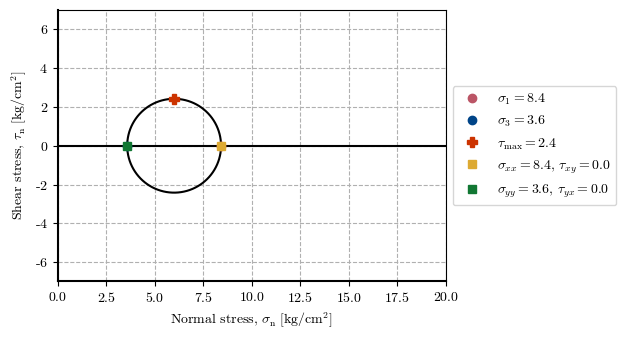

In [7]:
stage_b = plot_mohr_circle(sigma_xx=8.42, sigma_yy=3.58, tau_xy=0)
stage_b

### c. Reducción de $\tau_{yx}$ hasta $-2.0\,\mathrm{\frac{kg}{cm^2}}$
Lo cual es equivalente a un incremento de $\tau_\mathrm{xy}$ hasta $2.0\,\mathrm{\frac{kg}{cm^2}}$

{'sig_1': 9.13949040450835,
 'sig_3': 2.86050959549165,
 'sig_xx': 8.42,
 'sig_yy': 3.58,
 'tau_xy': 2.0,
 's': 6.0,
 't': 3.1394904045083503,
 'p': 4.953503198497216,
 'q': 6.2789808090167005}

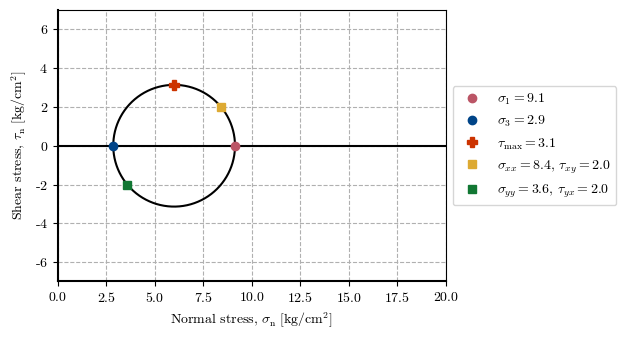

In [8]:
stage_c = plot_mohr_circle(sigma_xx=8.42, sigma_yy=3.58, tau_xy=2.0)
stage_c

### d. Aumento de $\sigma_\mathrm{v}$ hasta $8.42\,\mathrm{\frac{kg}{cm^2}}$ y reducción de $\sigma_\mathrm{h}$ hasta $3.58\,\mathrm{\frac{kg}{cm^2}}$

{'sig_1': 9.13949040450835,
 'sig_3': 2.86050959549165,
 'sig_xx': 3.58,
 'sig_yy': 8.42,
 'tau_xy': 2.0,
 's': 6.0,
 't': 3.1394904045083503,
 'p': 4.953503198497216,
 'q': 6.2789808090167005}

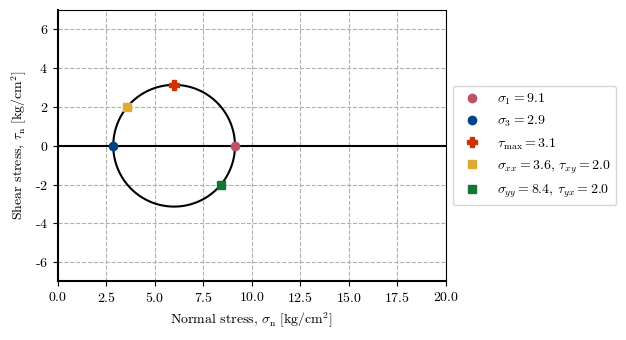

In [9]:
stage_d = plot_mohr_circle(sigma_xx=3.58, sigma_yy=8.42, tau_xy=2.0)
stage_d

### e. Aumento de $\sigma_{xx}$ hasta $10.0\,\mathrm{\frac{kg}{cm^2}}$ y de $\sigma_{yy}$ hasta $5.16\,\mathrm{\frac{kg}{cm^2}}$

{'sig_1': 10.719490404508349,
 'sig_3': 4.44050959549165,
 'sig_xx': 10.0,
 'sig_yy': 5.16,
 'tau_xy': 2.0,
 's': 7.58,
 't': 3.1394904045083494,
 'p': 6.5335031984972165,
 'q': 6.278980809016699}

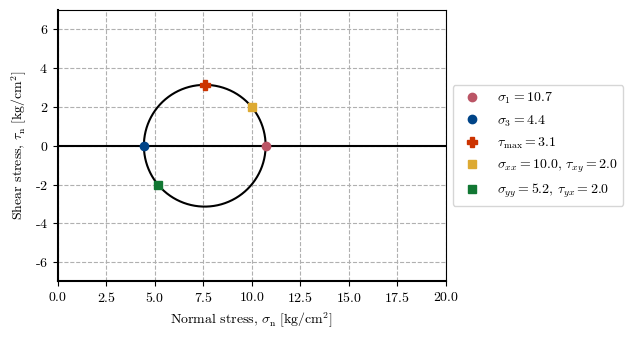

In [10]:
stage_e = plot_mohr_circle(sigma_xx=10.0, sigma_yy=5.16, tau_xy=2.0)
stage_e

### f. Reducción de $\sigma_{yy}$ hasta $4.58\,\mathrm{\frac{kg}{cm^2}}$

{'sig_1': 10.658100354799423,
 'sig_3': 3.9218996452005768,
 'sig_xx': 10.0,
 'sig_yy': 4.58,
 'tau_xy': 2.0,
 's': 7.29,
 't': 3.368100354799423,
 'p': 6.167299881733525,
 'q': 6.736200709598846}

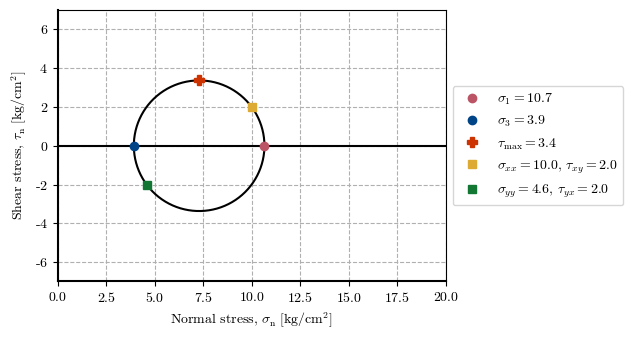

In [11]:
stage_f = plot_mohr_circle(sigma_xx=10.0, sigma_yy=4.58, tau_xy=2.0)
stage_f

### g. Aumento indefinido de $\sigma_\mathrm{xx}$.

Recordar que se tiene la hipótesis de que el suelo llega a rotura cuando $\tau_\mathrm{n} > 0.735 \sigma_\mathrm{n}$.


In [12]:
style = {'description_width': '100px'}
interact(  # Interactive widgets
    plot_mohr_circle,
    sigma_xx=widgets.FloatSlider(value=10, min=0, max=25, description="σ_xx", style=style),
    sigma_yy=widgets.FloatText(value=4.58, description="σ_yy", style=style),
    tau_xy=widgets.FloatText(value=2.0, description="𝜏_xy", style=style),
    plot_envelope=widgets.Checkbox(value=False, description="Plot envelope?", style=style),
    plot_pole=widgets.Checkbox(value=False, description="Plot pole?", style=style),
    plot_plane=widgets.Checkbox(value=False, description="Plot a plane?", style=style),
    alpha=widgets.FloatSlider(value=0, min=0, max=180, step=0.2, description="α", style=style),
    xlim=fixed((0, 20)),
    ylim=fixed((-8, 8)),
)

interactive(children=(FloatSlider(value=10.0, description='σ_xx', max=25.0, style=SliderStyle(description_widt…

<function __main__.plot_mohr_circle(sigma_xx, sigma_yy, tau_xy, plot_envelope=False, plot_pole=False, plot_plane=False, alpha=0, xlim=(0, 20), ylim=(-7, 7))>

{'sig_1': 16.583243266927788,
 'sig_3': 4.24675673307221,
 'sig_xx': 16.25,
 'sig_yy': 4.58,
 'tau_xy': 2.0,
 's': 10.415,
 't': 6.168243266927789,
 'p': 8.35891891102407,
 'q': 12.336486533855577}

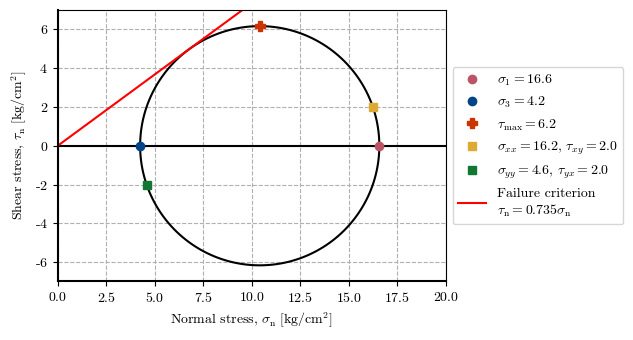

In [13]:
stage_g = plot_mohr_circle(sigma_xx=16.25, sigma_yy=4.58, tau_xy=2.0, plot_envelope=True)
stage_g

## El polo y las tensiones en un plano de interés

* Una vez verificado que si se llega a rotura en la trayectoria indicada, se desea saber ¿En qué plano se produce? y ¿cuáles son los esfuerzos sobre ese plano.

* ¿Cuál sería el ángulo del plano que estaría sometido al máximo esfuerzo cortante?

* ¿Ocurre una falla por el plano de mayor esfuerzo cortante?

In [14]:
style = {'description_width': '100px'}
interact(  # Interactive widgets
    plot_mohr_circle,
    sigma_xx=widgets.FloatSlider(value=16.25, min=0, max=25, description="σ_xx", style=style),
    sigma_yy=widgets.FloatText(value=4.58, description="σ_yy", style=style),
    tau_xy=widgets.FloatText(value=2.0, description="𝜏_xy", style=style),
    plot_envelope=widgets.Checkbox(value=False, description="Plot envelope?", style=style),
    plot_pole=widgets.Checkbox(value=False, description="Plot pole?", style=style),
    plot_plane=widgets.Checkbox(value=False, description="Plot a plane?", style=style),
    alpha=widgets.FloatSlider(value=0, min=0, max=180, step=0.2, description="α", style=style),xlim=fixed((0, 20)),
    ylim=fixed((-8, 8)),
)

interactive(children=(FloatSlider(value=16.25, description='σ_xx', max=25.0, style=SliderStyle(description_wid…

<function __main__.plot_mohr_circle(sigma_xx, sigma_yy, tau_xy, plot_envelope=False, plot_pole=False, plot_plane=False, alpha=0, xlim=(0, 20), ylim=(-7, 7))>

{'sig_1': 16.583243266927788,
 'sig_3': 4.24675673307221,
 'sig_xx': 16.25,
 'sig_yy': 4.58,
 'tau_xy': 2.0,
 's': 10.415,
 't': 6.168243266927789,
 'p': 8.35891891102407,
 'q': 12.336486533855577}

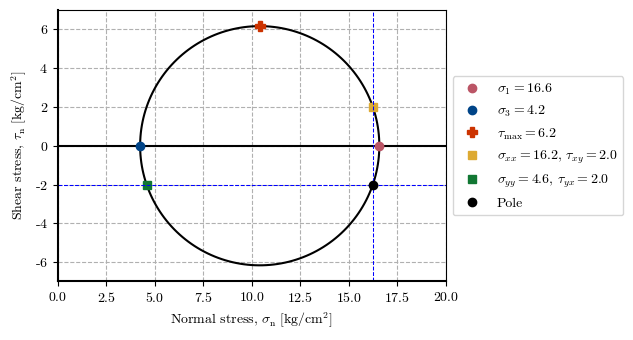

In [15]:
plot_mohr_circle(sigma_xx=16.25, sigma_yy=4.58, tau_xy=2.0, plot_pole=True)

## Trayectorias de esfuerzos

* Representar en los planos $(\sigma_1 - \sigma_3)$, $(s-t)$ y $(p-q)$ la trayectoria de tensiones correspondiente a las modificaciones de estados del ítem anterior.

**¡Importante!:** considerar la hipótesis de que el suelo llega a rotura cuando $\tau_\mathrm{n} > 0.735\sigma_\mathrm{n}$.

In [16]:
def plot_all_mohr_circles(stages):
    theta = np.linspace(0, 2 * np.pi, 200)
    # sigma = np.linspace(0, sig_1 * factor, 200)
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[6.5, 3.5])
    i = 0
    for st in stages:
        sigma_xx, sigma_yy, tau_xy = st['sig_xx'], st['sig_yy'], st['tau_xy']
        c = 0.5 * (sigma_xx + sigma_yy)
        r = np.sqrt((sigma_xx - c) ** 2 + tau_xy**2)
        sig_1 = r * np.cos(0) + c
        sig_3 = r * np.cos(np.pi) + c
        # ax.axhline(y=0, xmin=0, xmax=sig_1 * factor, c="k")
        ax.plot(r * np.cos(theta) + c, r * np.sin(theta), label=f'Stage {i}')  # Mohr circle
        i += 1
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.grid(True, ls="--")
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_linewidth(1.5)
    # ax.axis("equal")
    ax.set_aspect("equal", adjustable=None, anchor='C')
    ax.set(
        xlabel="Normal stress, $\sigma_\mathrm{n}\;[\mathrm{kg/cm^2}]$",
        ylabel="Shear stress, $\\tau_\mathrm{n}\;[\mathrm{kg/cm^2}]$")
    return



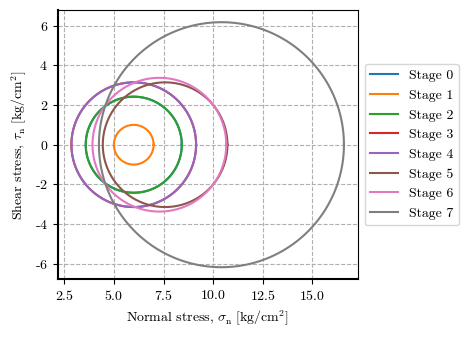

In [17]:
stages = (stage_0, stage_a, stage_b, stage_c, stage_d, stage_e, stage_f, stage_g)
plot_all_mohr_circles(stages)

In [18]:
def plot_stress_path(stages):
    sig_1, sig_3, s, t, p, q = [], [], [], [], [], []
    for st in stages:
        sig_1.append(st['sig_1'])
        sig_3.append(st['sig_3'])
        s.append(st['s'])
        t.append(st['t'])
        p.append(st['p'])
        q.append(st['q'])
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=[11, 4.0])
    # sigma_1, \sigma_3
    ax0.plot(sig_3, sig_1, ls="--", c="k", marker="o", mfc = "tomato", lw=0.75)
    s_3 = np.linspace(0, max(sig_1)*1.5)
    ax0.plot(
        s_3, s_3 * (1 +  np.sin(np.arctan(0.735))) / (1 - np.sin(np.arctan(0.735))), c="#BB5566",
        label="Failure criterion: \n$\sigma_1 = \sigma_3 \\frac{1 + \sin \phi'}{1 - \sin \phi'}$",
        )
    ax0.set(
        xlabel="$\sigma'_{3}\;[\mathrm{kg/cm^2}]$", ylabel="$\sigma'_{1}\;[\mathrm{kg/cm^2}]$",
        xlim=(0, 10), ylim=(0, 20)
    )
    # s, t
    ax1.plot(s, t, ls="--", c="k", marker="o", mfc = "tomato", lw=0.75)
    s_plot = np.linspace(0, max(s)*1.5)
    ax1.plot(
        s_plot, s_plot * np.sin(np.arctan(0.735)), c="#004488",
        label="Failure criterion: \n$t = s'\,\sin \phi'$"
        )
    ax1.set(
        xlabel="$s'\;[\mathrm{kg/cm^2}]$", ylabel="$t\;[\mathrm{kg/cm^2}]$",
        xlim=(0, 15), ylim=(0, 8)
    )
    # p, q
    m = 6 * np.sin(np.arctan(0.735)) / (3 - np.sin(np.arctan(0.735)))
    ax2.plot(p, q, ls="--", c="k", marker="o", mfc = "tomato", lw=0.75)
    ax2.plot(
            np.linspace(0, max(p)*1.5), m * np.linspace(0, max(p)*1.5),c="#DDAA33",
            label="Failure criterion: \n$q = \\frac{6\sin \phi'}{3 - \sin \phi'} p'$"
        )
    ax2.set(
        xlabel="$p\;[\mathrm{kg/cm^2}]$", ylabel="$q\;[\mathrm{kg/cm^2}]$",
        xlim=(0, 15), ylim=(0, 14)
    )

    for ax in (ax0, ax1, ax2):
        ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2))
        ax.grid(True, ls=":")
        ax.spines["bottom"].set_linewidth(1.5)
        ax.spines["left"].set_linewidth(1.5)
        
    fig.tight_layout()


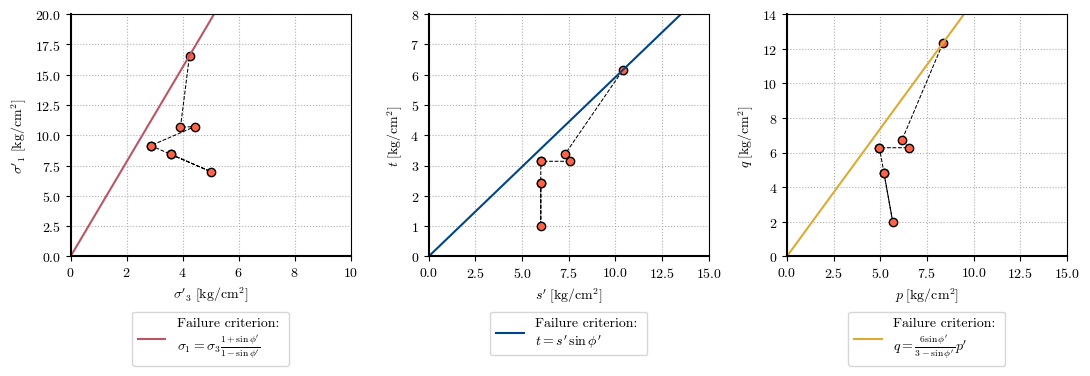

In [19]:
stages = (stage_0, stage_a, stage_b, stage_c, stage_d, stage_e, stage_f, stage_g)
plot_stress_path(stages)

In [20]:
def plot_unique_path(sigma_xx=10, sigma_yy=5, tau_xy=2.0):
    stage = plot_mohr_circle(sigma_xx, sigma_yy, tau_xy, plot_envelope=True, xlim=(0, 20), ylim=(-8, 8))
    plot_stress_path([stage])

style = {'description_width': '100px'}
interact(  # Interactive widgets
    plot_unique_path,
    sigma_xx=widgets.FloatSlider(value=7, min=0, max=25, description="σ_xx", style=style),
    sigma_yy=widgets.FloatSlider(value=5, min=0, max=25, description="σ_yy", style=style),
    tau_xy=widgets.FloatSlider(value=2.0, min=0, max=25, description="𝜏_xy", style=style)
)

interactive(children=(FloatSlider(value=7.0, description='σ_xx', max=25.0, style=SliderStyle(description_width…

<function __main__.plot_unique_path(sigma_xx=10, sigma_yy=5, tau_xy=2.0)>